1. Data and relevant library import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from myoDataUtils import * 
from tensorflow_model_optimization.quantization.keras import vitis_quantize

In [2]:
abs_path  = "/workspace/sEMG/MyoArmbandDataset/data/PreTrainingDataset"
male_subject = 12
total_female_subject = 10
total_exercise = 28

In [3]:
features, labels = get_data(abs_path, male_subject, total_female_subject, total_exercise)

2. Data Preparation

In [4]:
features = np.expand_dims(features, axis=3)
print("Feature Shape After Expansion is {}".format(features.shape))
print("Label shape {}".format(labels.shape))

Feature Shape After Expansion is (12934, 8, 52, 1)
Label shape (12934, 1)


In [5]:
# This trick work to avoid Nan loss. I guess a problem from my hardware :)

X_train_tensor = tf.constant(features, dtype=tf.float32)
y_train_tensor = tf.constant(labels, dtype=tf.uint8)

In [6]:
inputs = tf.keras.Input(shape=(8,52,1))
x = tf.keras.layers.Conv2D(6, 3, activation="relu", input_shape=(8,52,1))(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
x = tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dense(151, activation='relu')(x)
x = tf.keras.layers.Dense(17, activation='relu')(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="sEMG-classfier")
model.summary()

Model: "sEMG-classfier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 52, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 50, 6)          60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 48, 32)         1760      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 46, 16)         4624      
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense (Dense)                (None, 1500)              2209500   
_________________________________________________________________
dense_1 (Dense)              (None, 151)            

In [7]:
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-07, clipnorm=1)
ls = 'sparse_categorical_crossentropy'
mtr = 'accuracy'
n_batches = 32
n_epochs = 10
model.compile(optimizer=opt, loss=ls, metrics=mtr)

In [8]:
history = model.fit(X_train_tensor, y_train_tensor, validation_split=0.2, batch_size=n_batches, epochs= n_epochs)

Epoch 1/10
324/324 [==============================] - 6s 19ms/step - loss: 1.0272 - accuracy: 0.6030 - val_loss: 0.4028 - val_accuracy: 0.8612
Epoch 2/10
324/324 [==============================] - 6s 18ms/step - loss: 0.3457 - accuracy: 0.8776 - val_loss: 0.2489 - val_accuracy: 0.9119
Epoch 3/10
324/324 [==============================] - 6s 19ms/step - loss: 0.1935 - accuracy: 0.9316 - val_loss: 0.1564 - val_accuracy: 0.9436
Epoch 4/10
324/324 [==============================] - 6s 19ms/step - loss: 0.1359 - accuracy: 0.9527 - val_loss: 0.0744 - val_accuracy: 0.9741
Epoch 5/10
324/324 [==============================] - 6s 19ms/step - loss: 0.0973 - accuracy: 0.9672 - val_loss: 0.0502 - val_accuracy: 0.9822
Epoch 6/10
324/324 [==============================] - 6s 19ms/step - loss: 0.0564 - accuracy: 0.9789 - val_loss: 0.0496 - val_accuracy: 0.9842
Epoch 7/10
324/324 [==============================] - 6s 19ms/step - loss: 0.0571 - accuracy: 0.9829 - val_loss: 0.0781 - val_accuracy: 0.9791

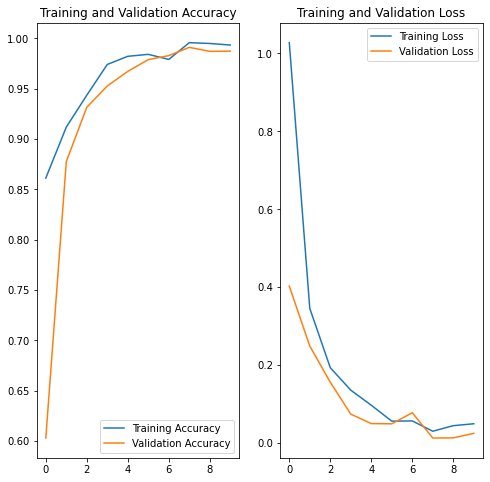

In [11]:
validation_loss = history.history['val_loss']
training_loss = history.history['loss']

validation_accuracy = history.history['accuracy']
training_accuracy = history.history['val_accuracy']

epoch_range = range(n_epochs)
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, training_accuracy, label = "Training Accuracy")
plt.plot(epoch_range, validation_accuracy, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epoch_range, training_loss, label = "Training Loss")
plt.plot(epoch_range, validation_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [12]:
saved_model = "sEMG-classifier.h5" 
model.save(saved_model)

4. Quantization

In [13]:
calibration_dataset = X_train_tensor[0:1000] # Note a minumum of 100 is needed and a maximum of 1000
evaluation_dataset = X_train_tensor[1000:]
evaluation_dataset_gnd = y_train_tensor[1000:]

In [14]:
saved_float32_model = tf.keras.models.load_model(saved_model)
ptq_quantizer = vitis_quantize.VitisQuantizer(saved_float32_model)
ptq_quantized_model = ptq_quantizer.quantize_model(calib_dataset=calibration_dataset)

[INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 56ms/step
[INFO] CrossLayerEqualization Done.
[INFO] Start Quantize Calibration...
20/20 [==============================] - 2s 80ms/step
[INFO] Quantize Calibration Done.
[INFO] Start Generating Quantized Model...
[Warning] Skip quantize pos adjustment for layer quant_dense, its quantize pos is [i=None, w=9.0, b=8.0, o=2.0]
[Warning] Skip quantize pos adjustment for layer quant_dense_1, its quantize pos is [i=2.0, w=9.0, b=9.0, o=0.0]
[Warning] Skip quantize pos adjustment for layer quant_dense_2, its quantize pos is [i=0.0, w=8.0, b=9.0, o=0.0]
[Warning] Skip quantize pos adjustment for layer quant_dense_3, its quantize pos is [i=0.0, w=7.0, b=8.0, o=0.0]
[INFO] Generating Quantized Model Done.


In [15]:
# Evalauting Post training quantization

ptq_quantized_model.compile(loss=ls, metrics=mtr)
ptq_quantized_model.evaluate(evaluation_dataset, evaluation_dataset_gnd)

373/373 [==============================] - 4s 9ms/step - loss: 0.0249 - accuracy: 0.9929


[0.024885525926947594, 0.9928774833679199]

In [16]:
# Saving post training quantization

quantized_model = "qunatized_sEMG_classifier.h5"
ptq_quantized_model.save(quantized_model)

In [17]:
!vai_c_tensorflow2 \
    --model ./qunatized_sEMG_classifier.h5 \
    --arch ./arch.json \
    --output_dir . \
    --net_name model

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(inputs_shape=None, layout='NHWC', model_files=['./qunatized_sEMG_classifier.h5'], model_type='tensorflow2', out_filename='./model_org.xmodel', proto=None)
[INFO] tensorflow2 model: qunatized_sEMG_classifier.h5
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/xnnc/translator/tensorflow_translator.py:1809: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  value = param.get(group).get(ds).value
[INFO] infer shape (NHWC)  :100%|█| 32/32 [00:00<00:00, 1981.78it/s]            
[OPT] No optimization method available for xir-level optimization.
[INFO] generate xmodel     :100%|█| 32/32 [00:00<00:00, 216.19it/s]             
[INFO] generate xmodel: /workspace/sEMG/MyoArmbandDataset/model_org.xmodel
[UNILOG][INFO] The compiler log will be dumped at "/tmp/vitis-ai-user/log/xcompiler-